# Chapter 1

In [127]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
import recordlinkage

In [2]:
ride_sharing = pd.read_csv('ride_sharing_new.csv')
# Convert tire_sizes to category
ride_sharing['tire_sizes'] = ride_sharing['tire_sizes'].astype('category')
# ride_sharing['ride_date'] = ride_sharing['ride_date'].astype('datetime64[ns]')

In [3]:
# Print the information of ride_sharing
print(ride_sharing.info())

# Print summary statistics of user_type column
print(ride_sharing['user_type'].describe())

# Convert user_type from integer to category
ride_sharing['user_type_cat'] = ride_sharing['user_type'].astype('category')

# Write an assert statement confirming the change
assert ride_sharing['user_type_cat'].dtype == 'category'

# Print new summary statistics 
print(ride_sharing['user_type_cat'].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25764 entries, 0 to 25763
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   ride_id          25764 non-null  int64   
 1   duration         25764 non-null  object  
 2   station_A_id     25764 non-null  int64   
 3   station_A_name   25764 non-null  object  
 4   station_B_id     25764 non-null  int64   
 5   station_B_name   25764 non-null  object  
 6   bike_id          25764 non-null  int64   
 7   user_type        25764 non-null  int64   
 8   user_birth_year  25764 non-null  int64   
 9   user_gender      25764 non-null  object  
 10  tire_sizes       25764 non-null  category
 11  ride_date        25764 non-null  object  
dtypes: category(1), int64(6), object(5)
memory usage: 2.2+ MB
None
count    25764.000000
mean         2.008384
std          0.704541
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max        

In [4]:
# Strip duration of minutes
ride_sharing['duration_trim'] = ride_sharing['duration'].str.strip('minutes')

# Convert duration to integer
ride_sharing['duration_time'] = ride_sharing['duration_trim'].astype('int')

# Write an assert statement making sure of conversion
assert ride_sharing['duration_time'].dtype == 'int'

# Print formed columns and calculate average ride duration 
print(ride_sharing[['duration','duration_trim','duration_time']])
print(ride_sharing['duration_time'].mean())

         duration duration_trim  duration_time
0      12 minutes           12              12
1      24 minutes           24              24
2       8 minutes            8               8
3       4 minutes            4               4
4      11 minutes           11              11
...           ...           ...            ...
25759  11 minutes           11              11
25760  10 minutes           10              10
25761  14 minutes           14              14
25762  14 minutes           14              14
25763  29 minutes           29              29

[25764 rows x 3 columns]
11.388487812451483


In [5]:
# Convert tire_sizes to integer
ride_sharing['tire_sizes'] = ride_sharing['tire_sizes'].astype('int')

# Set all values above 27 to 27
ride_sharing.loc[ride_sharing['tire_sizes'] > 27, 'tire_sizes'] = 27

# Reconvert tire_sizes back to categorical
ride_sharing['tire_sizes'] = ride_sharing['tire_sizes'].astype('category')

# Print tire size description
print(ride_sharing['tire_sizes'].describe())

count     25764
unique        2
top          27
freq      19477
Name: tire_sizes, dtype: int64


In [6]:
# Convert ride_date to datetime
ride_sharing['ride_dt'] = pd.to_datetime(ride_sharing['ride_date'])

# Save today's date
today = pd.to_datetime(dt.date.today())

# Set all in the future to today's date
ride_sharing.loc[ride_sharing['ride_dt'] > today, 'ride_dt'] = today

# Print maximum of ride_dt column
print(ride_sharing['ride_dt'].max())

2022-02-17 00:00:00


In [7]:
# Find duplicates
duplicates = ride_sharing.duplicated('ride_id', keep=False)

# Sort your duplicated rides
duplicated_rides = ride_sharing[duplicates].sort_values('ride_id')

# Print relevant columns of duplicated_rides
print(duplicated_rides[['ride_id','duration','user_birth_year']])

    ride_id    duration  user_birth_year
33       33   2 minutes             1979
34       33  16 minutes             1979
56       55  11 minutes             1985
57       55  11 minutes             1985
73       71  11 minutes             1997
74       71  11 minutes             1997
92       89   9 minutes             1986
93       89   9 minutes             2060


In [9]:
# Drop complete duplicates from ride_sharing
ride_dup = ride_sharing.drop_duplicates()

# Create statistics dictionary for aggregation function
statistics = {'user_birth_year': 'min', 'duration_time': 'mean'}

# Group by ride_id and compute new statistics
ride_unique = ride_dup.groupby('ride_id').agg(statistics).reset_index()

# Find duplicated values again
duplicates = ride_unique.duplicated(subset = 'ride_id', keep = False)
duplicated_rides = ride_unique[duplicates == True]

# Assert duplicates are processed
assert duplicated_rides.shape[0] == 0

In [10]:
print(ride_unique.head(50))

    ride_id  user_birth_year  duration_time
0         0             1959           12.0
1         1             1965           24.0
2         2             1993            8.0
3         3             1979            4.0
4         4             1994           11.0
5         5             1979           10.0
6         6             1981           16.0
7         7             1991            9.0
8         8             1982           21.0
9         9             1994            5.0
10       10             1983           19.0
11       11             1990            6.0
12       12             1998            7.0
13       13             1987          187.0
14       14             1997           13.0
15       15             1995            4.0
16       16             1990           32.0
17       17             1964            5.0
18       18             2000           16.0
19       19             2000           17.0
20       20             1998           16.0
21       21             1986    

# Chapter 2

In [35]:
airlines = pd.read_csv('airlines_final.csv')
categories = pd.read_csv('airline_categories.csv')

In [36]:
# Print categories DataFrame
print(categories)

# Print unique values of survey columns in airlines
print('Cleanliness: ', airlines['cleanliness'].unique(), "\n")
print('Safety: ', airlines['safety'].unique(), "\n")
print('Satisfaction: ', airlines['satisfaction'].unique(), "\n")

      cleanliness           safety          satisfaction
0           Clean          Neutral        Very satisfied
1         Average        Very safe               Neutral
2  Somewhat clean    Somewhat safe    Somewhat satisfied
3  Somewhat dirty      Very unsafe  Somewhat unsatisfied
4           Dirty  Somewhat unsafe      Very unsatisfied
Cleanliness:  ['Clean' 'Average' 'Unacceptable' 'Somewhat clean' 'Somewhat dirty'
 'Dirty'] 

Safety:  ['Neutral' 'Very safe' 'Somewhat safe' 'Very unsafe' 'Somewhat unsafe'] 

Satisfaction:  ['Very satisfied' 'Neutral' 'Somewhat satsified' 'Somewhat unsatisfied'
 'Very unsatisfied'] 



In [37]:
# Find the cleanliness category in airlines not in categories
cat_clean = set(airlines['cleanliness']).difference(categories['cleanliness'])

# Find rows with that category
cat_clean_rows = airlines['cleanliness'].isin(cat_clean)

# Print rows with inconsistent category
print(airlines[cat_clean_rows])

    Unnamed: 0    id        day           airline  destination  dest_region  \
4            4  2992  Wednesday          AMERICAN        MIAMI      East US   
17          18  2913     Friday  TURKISH AIRLINES     ISTANBUL  Middle East   
89         100  2321  Wednesday         SOUTHWEST  LOS ANGELES      West US   

   dest_size boarding_area   dept_time  wait_min   cleanliness         safety  \
4        Hub   Gates 50-59  12/31/2018       559  Unacceptable      Very safe   
17       Hub  Gates 91-102  12/31/2018       225  Unacceptable      Very safe   
89       Hub   Gates 20-39  12/31/2018       130  Unacceptable  Somewhat safe   

          satisfaction     full_name  \
4   Somewhat satsified  Michael Ward   
17  Somewhat satsified  Michael Ward   
89  Somewhat satsified  Michael Ward   

                                      survey_response  
4                                     It was terrible  
17                                          Not a fan  
89  The food in the airport w

In [38]:
print(airlines[~cat_clean_rows])

      Unnamed: 0    id       day        airline        destination  \
0              0  1351   Tuesday    UNITED INTL             KANSAI   
1              1   373    Friday         ALASKA  SAN JOSE DEL CABO   
2              2  2820  Thursday          DELTA        LOS ANGELES   
3              3  1157   Tuesday      SOUTHWEST        LOS ANGELES   
5              5   634  Thursday         ALASKA             NEWARK   
...          ...   ...       ...            ...                ...   
2472        2804  1475   Tuesday         ALASKA       NEW YORK-JFK   
2473        2805  2222  Thursday      SOUTHWEST            PHOENIX   
2474        2806  2684    Friday         UNITED            ORLANDO   
2475        2807  2549   Tuesday        JETBLUE         LONG BEACH   
2476        2808  2162  Saturday  CHINA EASTERN            QINGDAO   

        dest_region dest_size boarding_area   dept_time  wait_min  \
0              Asia       Hub  Gates 91-102  12/31/2018       115   
1     Canada/Mexico  

In [39]:
# Print unique values of both columns
print(airlines['dest_region'].unique())
print(airlines['dest_size'].unique())

['Asia' 'Canada/Mexico' 'West US' 'East US' 'Midwest US' 'EAST US'
 'Middle East' 'Europe' 'eur' 'Central/South America'
 'Australia/New Zealand' 'middle east']
['Hub' 'Small' '    Hub' 'Medium' 'Large' 'Hub     ' '    Small'
 'Medium     ' '    Medium' 'Small     ' '    Large' 'Large     ']


In [40]:
# Lower dest_region column and then replace "eur" with "europe"
airlines['dest_region'] = airlines['dest_region'].str.lower() 
airlines['dest_region'] = airlines['dest_region'].replace({'eur':'europe'})

# Remove white spaces from `dest_size`
airlines['dest_size'] = airlines['dest_size'].str.strip()

# Verify changes have been effected
print(airlines['dest_region'].unique())
print(airlines['dest_size'].unique())

['asia' 'canada/mexico' 'west us' 'east us' 'midwest us' 'middle east'
 'europe' 'central/south america' 'australia/new zealand']
['Hub' 'Small' 'Medium' 'Large']


In [41]:
# Create ranges for categories
label_ranges = [0, 60, 180, np.inf]
label_names = ['short', 'medium', 'long']

# Create wait_type column
airlines['wait_type'] = pd.cut(airlines['wait_min'], bins = label_ranges, 
                                labels = label_names)

# Create mappings and replace
mappings = {'Monday':'weekday', 'Tuesday':'weekday', 'Wednesday': 'weekday', 
            'Thursday': 'weekday', 'Friday': 'weekday', 
            'Saturday': 'weekend', 'Sunday': 'weekend'}

airlines['day_week'] = airlines['day'].replace(mappings)
print(airlines.head())

   Unnamed: 0    id        day      airline        destination    dest_region  \
0           0  1351    Tuesday  UNITED INTL             KANSAI           asia   
1           1   373     Friday       ALASKA  SAN JOSE DEL CABO  canada/mexico   
2           2  2820   Thursday        DELTA        LOS ANGELES        west us   
3           3  1157    Tuesday    SOUTHWEST        LOS ANGELES        west us   
4           4  2992  Wednesday     AMERICAN              MIAMI        east us   

  dest_size boarding_area   dept_time  wait_min   cleanliness         safety  \
0       Hub  Gates 91-102  12/31/2018       115         Clean        Neutral   
1     Small   Gates 50-59  12/31/2018       135         Clean      Very safe   
2       Hub   Gates 40-48  12/31/2018        70       Average  Somewhat safe   
3       Hub   Gates 20-39  12/31/2018       190         Clean      Very safe   
4       Hub   Gates 50-59  12/31/2018       559  Unacceptable      Very safe   

         satisfaction         fu

In [42]:
# Replace "Dr." with empty string ""
airlines['full_name'] = airlines['full_name'].str.replace("Dr.","")

# Replace "Mr." with empty string ""
airlines['full_name'] = airlines['full_name'].str.replace("Mr.","")

# Replace "Miss" with empty string ""
airlines['full_name'] = airlines['full_name'].str.replace("Miss","")

# Replace "Ms." with empty string ""
airlines['full_name'] = airlines['full_name'].str.replace("Ms.","")

# Assert that full_name has no honorifics
assert airlines['full_name'].str.contains('Ms.|Mr.|Miss|Dr.').any() == False

C:\Users\mkars\AppData\Local\Temp/ipykernel_23428/3304348909.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  airlines['full_name'] = airlines['full_name'].str.replace("Dr.","")
C:\Users\mkars\AppData\Local\Temp/ipykernel_23428/3304348909.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  airlines['full_name'] = airlines['full_name'].str.replace("Mr.","")
C:\Users\mkars\AppData\Local\Temp/ipykernel_23428/3304348909.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  airlines['full_name'] = airlines['full_name'].str.replace("Ms.","")


In [45]:
# Store length of each row in survey_response column
resp_length = airlines['survey_response'].str.len()

# Find rows in airlines where resp_length > 40
airlines_survey = airlines[resp_length > 40]

# Assert minimum survey_response length is > 40
assert airlines_survey['survey_response'].str.len().min() > 40

# Print new survey_response column
print(airlines_survey['survey_response'])

43      The airport personnell forgot to alert us of d...
44      The airport personnell forgot to alert us of d...
45      The airport personnell forgot to alert us of d...
46      The airport personnell forgot to alert us of d...
47      The airport personnell forgot to alert us of d...
                              ...                        
2472    One of the other travelers was really loud and...
2473    One of the other travelers was really loud and...
2474    One of the other travelers was really loud and...
2475    One of the other travelers was really loud and...
2476    One of the other travelers was really loud and...
Name: survey_response, Length: 2434, dtype: object


# Chapter 3

In [87]:
banking = pd.read_csv('banking_dirty.csv')

In [88]:
# Find values of acct_cur that are equal to 'euro'
acct_eu = banking['acct_cur'] == 'euro'

# Convert acct_amount where it is in euro to dollars
banking.loc[acct_eu, 'acct_amount'] = banking.loc[acct_eu, 'acct_amount'] * 1.1

# Unify acct_cur column by changing 'euro' values to 'dollar'
banking.loc[acct_eu, 'acct_cur'] = 'dollar'

# Assert that only dollar currency remains
assert banking['acct_cur'].unique() == 'dollar'

In [89]:
# Print the header of account_opend
print(banking['account_opened'].head())

# Convert account_opened to datetime
banking['account_opened'] = pd.to_datetime(banking['account_opened'],
                                           # Infer datetime format
                                           infer_datetime_format = True,
                                           # Return missing value for error
                                           errors = 'coerce') 

# Get year of account opened
banking['acct_year'] = banking['account_opened'].dt.strftime('%Y')

# Print acct_year
print(banking['acct_year'])

0     2/9/2018
1     28-02-19
2     25-04-18
3    7/11/2017
4     14-05-18
Name: account_opened, dtype: object
0     2018
1      NaN
2      NaN
3     2017
4      NaN
      ... 
95     NaN
96    2017
97     NaN
98    2017
99    2017
Name: acct_year, Length: 100, dtype: object


In [90]:
# Store fund columns to sum against
fund_columns = ['fund_A', 'fund_B', 'fund_C', 'fund_D']

# Find rows where fund_columns row sum == inv_amount
inv_equ = banking[fund_columns].sum(axis = 1) == banking['inv_amount']

# Store consistent and inconsistent data
consistent_inv = banking[inv_equ]
inconsistent_inv = banking[~inv_equ]

# Store consistent and inconsistent data
print("Number of inconsistent investments: ", inconsistent_inv.shape[0])

Number of inconsistent investments:  20


In [91]:
# Store today's date and find ages
# today = pd.to_datetime(dt.date.today())
today = pd.to_datetime('2020-01-01')
ages_manual = today.year - pd.to_datetime(banking['birth_date']).dt.year

# Find rows where age column == ages_manual
age_equ = ages_manual == banking['age']

# Store consistent and inconsistent data
consistent_ages = banking[age_equ]
inconsistent_ages = banking[~age_equ]

# Store consistent and inconsistent data
print("Number of inconsistent ages: ", inconsistent_ages.shape[0])

Number of inconsistent ages:  8


Unnamed: 0           0
cust_id              9
birth_date           0
age                  0
acct_amount         14
inv_amount          12
fund_A              12
fund_B              12
fund_C              12
fund_D              12
account_opened      60
last_transaction     0
acct_cur             0
acct_year           60
dtype: int64


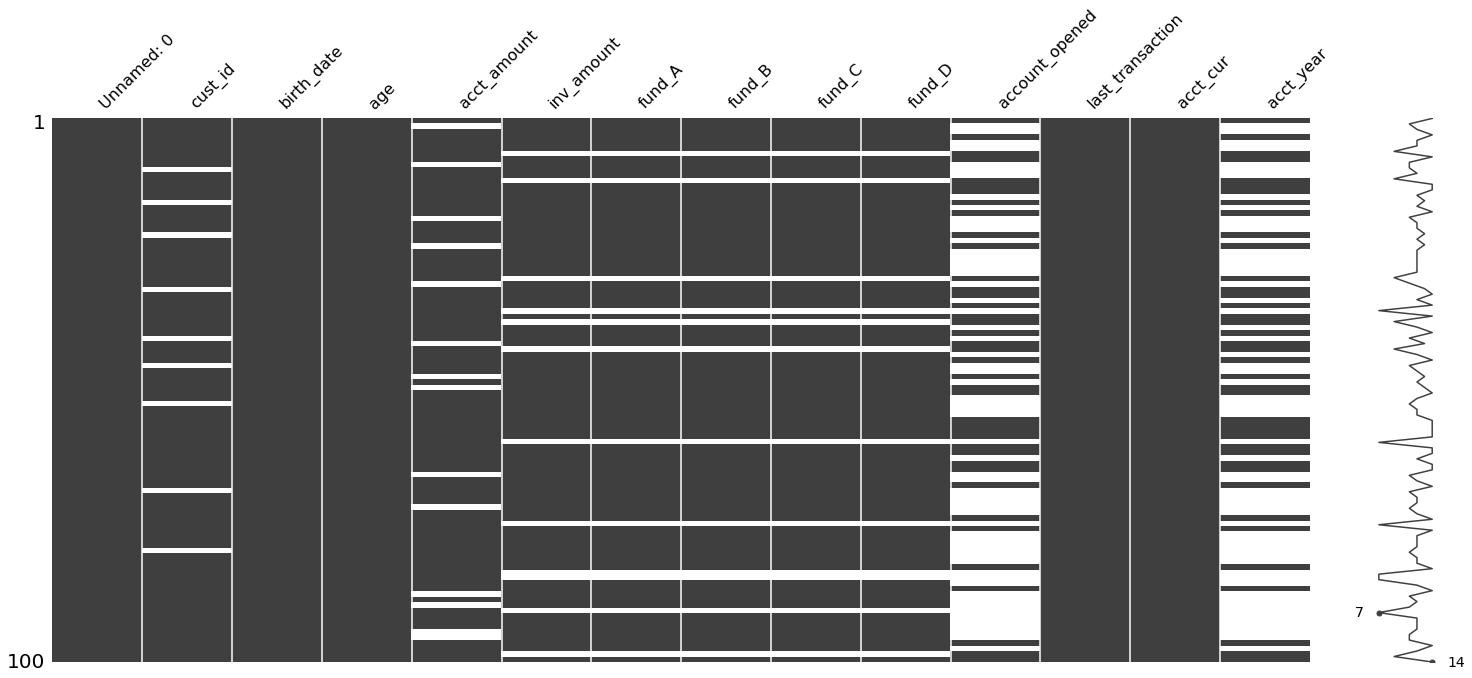

In [92]:
# Print number of missing values in banking
print(banking.isna().sum())

# Visualize missingness matrix
msno.matrix(banking)
plt.show()

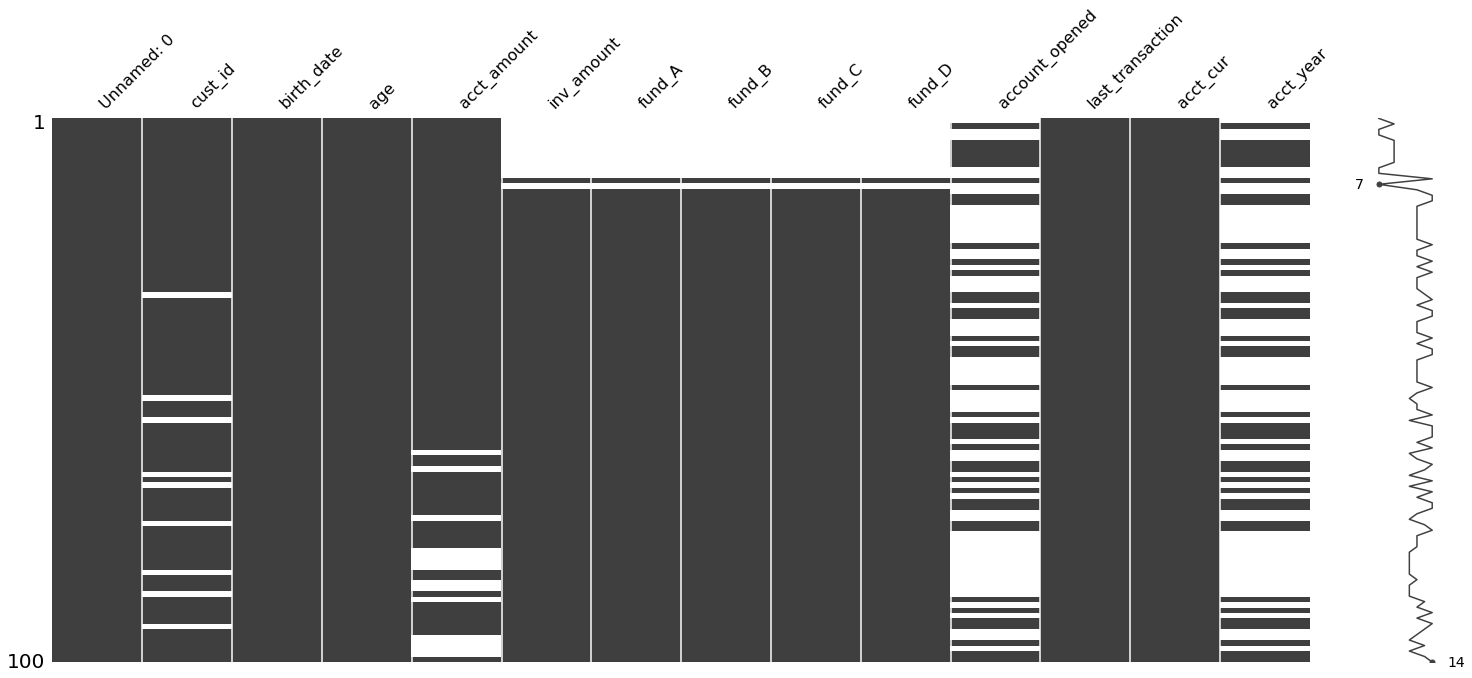

In [93]:
# Sort banking by age and visualize
banking_sorted = banking.sort_values(by='age')
msno.matrix(banking_sorted)
plt.show()

In [94]:
# Drop missing values of cust_id
banking_fullid = banking.dropna(subset = ['cust_id'])

# Compute estimated acct_amount
acct_imp = banking_fullid['inv_amount'] * 5

# Impute missing acct_amount with corresponding acct_imp
banking_imputed = banking_fullid.fillna({'acct_amount':acct_imp})

# Print number of missing values
print(banking_imputed.isna().sum())

Unnamed: 0           0
cust_id              0
birth_date           0
age                  0
acct_amount          0
inv_amount          12
fund_A              12
fund_B              12
fund_C              12
fund_D              12
account_opened      54
last_transaction     0
acct_cur             0
acct_year           54
dtype: int64


# Chapter 4

In [99]:
fuzz.WRatio('Houston Rockets', 'Rockets')

90

In [100]:
fuzz.WRatio('Houston Rockets vs Los Angeles Lakers', 'Lakers vs Rockets')

86

In [102]:
fuzz.WRatio('Osama bin Laden', 'Barack Hussein Obama')

48

In [129]:
restaurants = pd.read_csv('restaurants_L2_dirty (mpw).csv')

In [130]:
print(restaurants['cuisine_type'].unique())

['american' 'ammereican' 'californian' 'japanese' 'cajun/creole'
 'hot dogs' 'diners' 'america' 'delis' 'hamburgers' 'seafood' 'merican'
 'italiian' 'coffee shops' 'russian' 'steakhouses' 'mexican/tex-mex'
 'ameerrican' 'italiann' 'asiian' 'mexican' 'middle eastern' 'asiane'
 'amurican' 'americen' 'asiaan' 'asian' 'vietnamese' 'health food'
 'american ( new )' 'pacific new wave' 'americann' 'ameerican'
 'indonesian' 'eclectic' 'ameriican' 'chicken' 'fast food' 'italiaan'
 'southern/soul' 'amerycan' 'aamerican' 'amerrican' 'murican' 'coffeebar'
 'itali' 'continental' 'french ( new )' 'asiann' 'americano' 'desserts'
 'asianne' 'italien' 'americin' 'italiano' 'italianne' 'chinese'
 'itallian' 'asiat' 'ammericann']


In [131]:
# Store the unique values of cuisine_type in unique_types
unique_types = restaurants['cuisine_type'].unique()

# Calculate similarity of 'asian' to all values of unique_types
print(process.extract('asian', unique_types, limit = len(unique_types)))

# Calculate similarity of 'american' to all values of unique_types
print(process.extract('american', unique_types, limit = len(unique_types)))

# Calculate similarity of 'italian' to all values of unique_types
print(process.extract('italian', unique_types, limit = len(unique_types)))

[('asian', 100), ('asiian', 91), ('asiane', 91), ('asiaan', 91), ('asiann', 91), ('asianne', 83), ('asiat', 80), ('italiann', 72), ('indonesian', 72), ('italiano', 72), ('italianne', 72), ('russian', 67), ('american', 62), ('italiian', 62), ('amurican', 62), ('italiaan', 62), ('itallian', 62), ('americann', 57), ('ameerican', 57), ('ameriican', 57), ('aamerican', 57), ('amerrican', 57), ('americano', 57), ('ammereican', 54), ('californian', 54), ('japanese', 54), ('mexican/tex-mex', 54), ('ameerrican', 54), ('american ( new )', 54), ('ammericann', 54), ('america', 50), ('merican', 50), ('mexican', 50), ('murican', 50), ('italien', 50), ('americen', 46), ('amerycan', 46), ('americin', 46), ('itali', 40), ('cajun/creole', 36), ('diners', 36), ('middle eastern', 36), ('vietnamese', 36), ('pacific new wave', 36), ('fast food', 36), ('continental', 36), ('seafood', 33), ('chicken', 33), ('chinese', 33), ('hamburgers', 27), ('steakhouses', 25), ('southern/soul', 22), ('delis', 20), ('hot dog

In [132]:
categories = ['italian', 'asian', 'american']

# Iterate through categories
for cuisine in categories:  
  # Create a list of matches, comparing cuisine with the cuisine_type column
  matches = process.extract(cuisine, restaurants['cuisine_type'].unique(), limit=len(restaurants['cuisine_type'].unique()))

  # Iterate through the list of matches
  for match in matches:
     # Check whether the similarity score is greater than or equal to 80
    if match[1] >= 80:
      # If it is, select all rows where the cuisine_type is spelled this way, and set them to the correct cuisine
      restaurants.loc[restaurants['cuisine_type'] == match[0]] = cuisine
      
# Inspect the final result
print(restaurants['cuisine_type'].unique())

['american' 'californian' 'japanese' 'cajun/creole' 'hot dogs' 'diners'
 'delis' 'hamburgers' 'seafood' 'italian' 'coffee shops' 'russian'
 'steakhouses' 'mexican/tex-mex' 'asian' 'middle eastern' 'vietnamese'
 'health food' 'pacific new wave' 'indonesian' 'eclectic' 'chicken'
 'fast food' 'southern/soul' 'coffeebar' 'continental' 'french ( new )'
 'desserts' 'chinese']


# Chapter 4 - part 2

In [133]:
restaurants = pd.read_csv('restaurants_L2_dirty.csv')
restaurants_new = pd.read_csv('restaurants_L2.csv')

In [135]:
# Create an indexer and object and find possible pairs
indexer = recordlinkage.Index()

# Block pairing on cuisine_type
indexer.block('cuisine_type')

# Generate pairs
pairs = indexer.index(restaurants, restaurants_new)
print(pairs)

MultiIndex([( 0,   0),
            ( 0,   1),
            ( 0,   2),
            ( 0,   3),
            ( 0,   4),
            ( 0,   8),
            ( 0,   9),
            ( 0,  13),
            ( 0,  14),
            ( 0,  17),
            ...
            (55, 172),
            (55, 180),
            (55, 190),
            (55, 194),
            (55, 201),
            (55, 221),
            (55, 230),
            (55, 233),
            (55, 238),
            (55, 241)],
           length=3631)


In [136]:
# Create a comparison object
comp_cl = recordlinkage.Compare()

# Find exact matches on city, cuisine_types - 
comp_cl.exact('city', 'city', label='city')
comp_cl.exact('cuisine_type', 'cuisine_type', label='cuisine_type')

# Find similar matches of rest_name
comp_cl.string('rest_name', 'rest_name', label='name', threshold = 0.8) 

# Get potential matches and print
potential_matches = comp_cl.compute(pairs, restaurants, restaurants_new)
print(potential_matches)

        city  cuisine_type  name
0  0       0             1   0.0
   1       0             1   0.0
   2       0             1   0.0
   3       0             1   0.0
   4       0             1   0.0
...      ...           ...   ...
55 221     1             1   0.0
   230     1             1   0.0
   233     1             1   0.0
   238     1             1   0.0
   241     1             1   0.0

[3631 rows x 3 columns]


In [140]:
# Isolate potential matches with row sum >=3
matches = potential_matches[potential_matches.sum(axis = 1) >= 3]
print(matches)

       city  cuisine_type  name
1  3      1             1   1.0
7  13     1             1   1.0
12 17     1             1   1.0
20 20     1             1   1.0
27 21     1             1   1.0
28 1      1             1   1.0
40 0      1             1   1.0
43 8      1             1   1.0
50 9      1             1   1.0
53 4      1             1   1.0
67 14     1             1   1.0
74 2      1             1   1.0
21 11     1             1   1.0
47 19     1             1   1.0
57 16     1             1   1.0
73 6      1             1   1.0
75 10     1             1   1.0
26 12     1             1   1.0
65 5      1             1   1.0
71 18     1             1   1.0
79 7      1             1   1.0
55 15     1             1   1.0


In [141]:
# Get values of second column index of matches
matching_indices = matches.index.get_level_values(1)

# Subset restaurants_new based on non-duplicate values
non_dup = restaurants_new[~restaurants_new.index.isin(matching_indices)]
print(non_dup)

     Unnamed: 0           rest_name  \
22           22     gramercy tavern   
23           23               jo jo   
24           24          lespinasse   
25           25               march   
26           26          mesa grill   
..          ...                 ...   
331         331   vivande porta via   
332         332  vivande ristorante   
333         333        world wrapps   
334         334             wu kong   
335         335           yank sing   

                                            rest_addr           city  \
22   42 e. 20th st. between park ave. s and broadway        new york   
23                                   160 e. 64th st.        new york   
24                                     2 e. 55th st.        new york   
25                                   405 e. 58th st.        new york   
26          102 5th ave. between 15th and 16th sts .        new york   
..                                                ...            ...   
331                        

In [142]:
# Append non_dup to restaurants
full_restaurants = restaurants.append(non_dup)
print(full_restaurants)

     Unnamed: 0           rest_name                 rest_addr           city  \
0             0              kokomo         6333 w. third st.             la   
1             1              feenix   8358 sunset blvd. west       hollywood   
2             2             parkway      510 s. arroyo pkwy .       pasadena   
3             3                r-23          923 e. third st.    los angeles   
4             4               gumbo         6333 w. third st.             la   
..          ...                 ...                       ...            ...   
331         331   vivande porta via        2125 fillmore st.   san francisco   
332         332  vivande ristorante     670 golden gate ave.   san francisco   
333         333        world wrapps        2257 chestnut st.   san francisco   
334         334             wu kong            101 spear st.   san francisco   
335         335           yank sing          427 battery st.   san francisco   

          phone  cuisine_type  
0    21